此项目将用一个包含汽车多种细节的数据集，例如：车门数量、后备箱大小、维修成本等来确定汽车的质量。    
分类的目的是把车辆的质量分成4种不同类型：不达标、达标、良好、优秀

数据集在car.data.txt文件中     
需要把数据集中的每个值看成是字符串。考虑数据集中的6个属性，其取值范围是这样的：
- buying：vhigh,high,med,low
- maint:vhigh,high,med,low
- doors:2,3,4,5等
- persons：2,4等
- lug_boot:small,med,big
- safety:low,med,high

考虑到每一行都包含字符串属性，需要假设所有特征都是字符串，并设置分类器   
这里我们使用随机森林分类器

In [36]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 读取数据
def txt_read(filename,delim):
    x_data = []
    with open(filename,'r') as f:
        for line in f:
            data = line.strip().split(delim)
            x_data.append(data)

    x_data = np.array(x_data)
    return x_data 

x_data = txt_read('car.data.txt',',')


# 将字符串转化为数值
label_encoder = []
x_encoded = np.empty(x_data.shape)
for i,item in enumerate(x_data[0]):
    label_encoder.append(preprocessing.LabelEncoder()) # 为不同的属性使用不同的编码器
    x_encoded[:,i] = label_encoder[-1].fit_transform(x_data[:,i])
    
x_values = x_encoded[:,:-1].astype(int)
y_values = x_encoded[:,-1].astype(int) # 每一行的最后一个值是分类结果

In [37]:
# 接下来建立随机森林分类器
params = {'n_estimators':200,'max_depth':8,'random_state':7}
classifier = RandomForestClassifier(**params)
classifier.fit(x_values,y_values)

# 交叉验证
from sklearn.model_selection import cross_val_score
num_validation = 3 # 使用3折交叉验证（把数据分为3组，轮换着用其中两组数据验证分类器）
accuracy = cross_val_score(classifier,x_values,y_values,scoring='accuracy',cv=num_validation)
print('Accuracy:',round(100*accuracy.mean(),2),'%')

Accuracy: 78.19 %


In [39]:
# 对单一数据示例进行编码测试
input_data = ['vhigh', 'vhigh', '2', '2', 'small', 'low']
input_data_encoded = [-1]*len(input_data)

for i,item in enumerate(input_data):
    contain = []
    contain.append(item)
    input_data_encoded[i] = int(label_encoder[i].transform(contain))
    
input_data_encoded = np.array(input_data_encoded).reshape(1,-1)
output_class = classifier.predict(input_data_encoded)
print('Output class:',label_encoder[-1].inverse_transform(output_class))

Output class: ['unacc']


前面用随机森林建立了分类器，但是并不知道如何定义参数。    
本节来处理两个参数：n_estimators,max_depth,它们被称为超参数，分类器的性能由它们决定     
当改变超参数时，如果可以看到分类器性能的变化情况，那就再好不过了，这就是验证曲线的作用。这些曲线可以帮助理解
每个超参数对训练得分的影响。基本上，我们只对感兴趣的超参数进行调整，其他参数可以保持不变。下面将通过可视化图片
演示超参数变化对训练得分的影响

In [59]:
# 验证曲线
from sklearn.model_selection import validation_curve

classifier = RandomForestClassifier(max_depth=4,random_state=7)
parameter_grid = np.linspace(25,200,8).astype(int) # [25,200]分成8等分
train_scores,validation_scores = validation_curve(classifier,x_values,y_values,'n_estimators',parameter_grid,cv=5)
print('###### VALIDATIONCURVES ######')
print('Param:n_estimators\nTraining scores:\n',train_scores)
print('Param:n_estimators\nValidation scores:\n',validation_scores)

###### VALIDATIONCURVES ######
Param:n_estimators
Training scores:
 [[0.80680174 0.80824891 0.80752533 0.80463097 0.81358382]
 [0.79522431 0.80535456 0.81041968 0.8089725  0.81069364]
 [0.80101302 0.80680174 0.81114327 0.81476122 0.8150289 ]
 [0.8024602  0.80535456 0.81186686 0.80752533 0.80346821]
 [0.80028944 0.80463097 0.81114327 0.80824891 0.81069364]
 [0.80390738 0.80535456 0.81041968 0.80969609 0.81647399]
 [0.80390738 0.80463097 0.81114327 0.81476122 0.81719653]
 [0.80390738 0.80607815 0.81114327 0.81403763 0.81647399]]
Param:n_estimators
Validation scores:
 [[0.71098266 0.76589595 0.72543353 0.76300578 0.75290698]
 [0.71098266 0.75433526 0.71965318 0.75722543 0.74127907]
 [0.71098266 0.72254335 0.71965318 0.75722543 0.74418605]
 [0.71098266 0.71387283 0.71965318 0.75722543 0.72674419]
 [0.71098266 0.74277457 0.71965318 0.75722543 0.74127907]
 [0.71098266 0.74277457 0.71965318 0.75722543 0.74127907]
 [0.71098266 0.74566474 0.71965318 0.75722543 0.74418605]
 [0.71098266 0.7514450

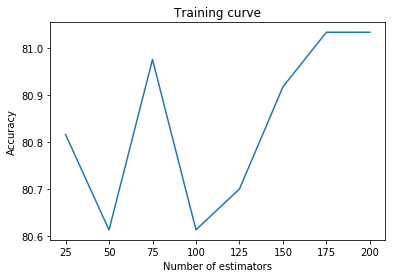

In [54]:
# 画出曲线图
import matplotlib.pyplot as plt
plt.figure()
plt.plot(parameter_grid,100*np.average(train_scores,axis=1))
plt.title('Training curve')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.show()

In [62]:
# 用类似的方法对max_depth参数进行验证

from sklearn.model_selection import validation_curve

classifier = RandomForestClassifier(n_estimators=20,random_state=7)
parameter_grid = np.linspace(2,10,5).astype(int)
train_scores,validation_scores = validation_curve(classifier,x_values,y_values,'max_depth',parameter_grid,cv=5)
print('###### VALIDATIONCURVES ######')
print('Param:max_depth\nTraining scores:\n',train_scores)
print('Param:max_depth\nValidation scores:\n',validation_scores)

###### VALIDATIONCURVES ######
Param:max_depth
Training scores:
 [[0.71852388 0.70043415 0.70043415 0.70043415 0.69942197]
 [0.80607815 0.80535456 0.80752533 0.79450072 0.81069364]
 [0.90665702 0.91027496 0.92836469 0.89797395 0.90679191]
 [0.97467438 0.96743849 0.96888567 0.97829233 0.96820809]
 [0.99421129 0.99710564 0.99782923 0.99855282 0.99277457]]
Param:max_depth
Validation scores:
 [[0.69942197 0.69942197 0.69942197 0.69942197 0.70348837]
 [0.71098266 0.76589595 0.72543353 0.75722543 0.74127907]
 [0.71387283 0.76300578 0.7283237  0.84682081 0.84011628]
 [0.67630058 0.78612717 0.78034682 0.80346821 0.89825581]
 [0.6416185  0.76878613 0.75722543 0.84393064 0.88081395]]


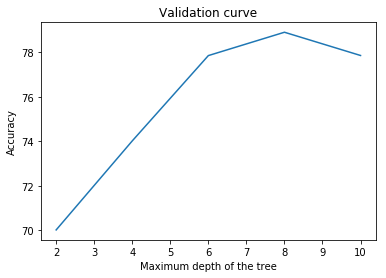

In [63]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(parameter_grid,100*np.average(validation_scores,axis=1))
plt.title('Validation curve')
plt.xlabel('Maximum depth of the tree')
plt.ylabel('Accuracy')
plt.show()

## 生成学习曲线
学习曲线可以帮助我们理解训练数据集的大小对机器学习模型的影响。      
当遇到计算能力限制时，这一点非常有用。    
下面改变训练数据集的大小，把学习曲线画出来

In [69]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import learning_curve

classifier = RandomForestClassifier(random_state=7)
parameter_grid = np.linspace(200,1100,4).astype(int)
train_sizes,train_scores,validation_scores = learning_curve(classifier,x_values,y_values,train_sizes=parameter_grid,cv=5)
print('##### LEARING CURVE ####')
print('Training scores:\n',train_scores)
print('Validation scaores\n',validation_scores)

##### LEARING CURVE ####
Training scores:
 [[1.         1.         1.         1.         1.        ]
 [1.         1.         0.998      0.998      0.998     ]
 [0.99875    0.9975     0.99875    0.99875    0.99875   ]
 [0.99818182 0.99545455 0.99909091 0.99818182 0.99818182]]
Validation scaores
 [[0.69942197 0.69942197 0.69942197 0.69942197 0.70348837]
 [0.74855491 0.65028902 0.76878613 0.76589595 0.70348837]
 [0.70520231 0.78612717 0.52312139 0.76878613 0.77034884]
 [0.65028902 0.75433526 0.65317919 0.75433526 0.76744186]]
